# GOAL: get fashion-mnist training to 90% of accuracy

In [1]:
import torch
import numpy as np
import random
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import torchvision.transforms.functional as TF

import fastcore.all as fc

from lib import *

In [2]:
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [3]:
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)
metrics = MetricCB(MulticlassAccuracy(10))

In [4]:
x,y = 'image','label'
dsd = load_dataset("fashion_mnist")
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding= ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res


def get_model():
    return nn.Sequential(
        conv(1, 8), # 14x14
        conv(8, 16), # 7x7
        conv(16, 32), # 4x4
        conv(32, 64), # 2x2
        conv(64, 10, act=False), #1x1
        nn.Flatten()).to(device) # flatten removes unit axis

Wwe want to force the cnn to learn stuff so we need to change-, layer by layer the number of filters -> core idea: decrease number of activations -> i.e. decrease the size of the pic grid + at the same time increase the number of filters. We want the cnn to be able to find a way to compress info intelligently -> reduce obs dims but layer after layer give it more room/more filters.
Also we can always use the same ammount of compute -> if we data size decreases we can increase filters.

Core idea: compression

Let's try to find a lr for this cnn using lrfinder

In [ ]:
cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr =1e-4, cbs=cbs)
learn.fit(1)

The model is so naive that the LRFinderCB does not work.
We need to tweak the parameters of the LRFinderCB: we reduce the multiplicative factor of the lr at each batch + we start with a larger lr cuz too small was useless. 

In [ ]:
cbs = [DeviceCB(), ProgressCB(), LRFinderCB(gamma=1.05)] 
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr =1e-2, cbs=cbs)
learn.fit(1)

So let's try different values of lr: 

In [ ]:
metrics = MetricCB(MulticlassAccuracy(10))
astats = ActivationStats(append_stats, fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats] 
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr =1e-1, cbs=cbs)
learn.fit(1)

In [ ]:
astats.color_dim()

In [ ]:
astats.dead_chart()

In [ ]:
astats.plot_stats()

The core problem is that since the beginning we don't have activations distributed as N(0,1).

# Glorot/Xavier initialization
### Motivation:

In [ ]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100)
x[:5,:5]

In [ ]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ (torch.randn(100, 100) * .01)
x[:5,:5]

Even if we initialize weights via :
torch.randn: Returns a tensor filled with random numbers from a normal distribution
with mean `0` and variance `1` (also called the standard normal
distribution).

If we multiply these weights many times if they are too big -> overflow (nan)
If too small -> underflow, all 0s -> all washed out.

We need to scale weights s.t. std of activations stays at 1 -> Xavier Glorot paper says 1/sqrt(inp_dimensionality)

In [ ]:
import math
x = torch.randn(200, 100) #n_in = 100 
for i in range(50):
    x = x @ (torch.randn(100, 100) * (1/math.sqrt(100)))
x[:5,:5]

Recalling that the variance is represents how data is spread around the mean:
$$ \operatorname{Var}(X) = \sum_{i=1}^n p_i\cdot(x_i - \mu)^2 $$

and can be computed as:
$$  \operatorname{Var}(X) = \operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2 $$

second version easier to compute. Variance is not in the same scale of data points, std is scaled.

In the same way convariance can be computed as:
$$ \operatorname{cov}(X, Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]} $$

or 
$$
\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$ 
and it represents how much two things are related. Covariance is not sacled wrt data so we can use the pearson corr to have its scaled version:
$$ \rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y} $$

scaled cuz the result always has a value between −1 and 1.


So let's go back to study the mean and the var of our activations over a chain of multiplications

In [ ]:
mean, sqrt = 0., 0.
steps = 100
for i in range(steps):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqrt += y.pow(2).mean().item()
    
mean/steps, sqrt/steps # size of input -> we thus need to scale by a factor to make this 1

there is a problem tho: RELU

In [ ]:
input_size_dimensionality = 100
x = torch.randn(200, input_size_dimensionality)
y = torch.randn(200)

w1 = torch.randn(input_size_dimensionality, 50) /math.sqrt(input_size_dimensionality)
b1 = torch.zeros (50)
w2 = torch.randn(50, 1) / math.sqrt(50)
b2 = torch.zeros(1)

def lin_layer(x, w, b):
    return x @ w + b

def relu(x):
    return x.clamp_min(0.)

In [ ]:
l1 = lin_layer(x,w1,b1)
l1.mean(), l1.std() # ok

In [ ]:
l2 = relu(l1)
l2.mean(), l2.std() # NOT ok

In [ ]:
# test over chain of multiplications
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ (torch.randn(100, 100) * .01))
x[:5,:5] # <- underflow!

# Kaiming/He
This initialization should solve relu problem -> scale by 
$$ \sqrt(2/\text{inp_dim})$$

In [ ]:
# test over chain of multiplications
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ (torch.randn(100, 100) * (math.sqrt(2/100))))
x[:5,:5] # <- ok even if we have some zeros

# How to apply this to nn weights

In [ ]:
model = get_model(); model

In [ ]:
model.apply(lambda module: print(type(module).__name__)) # loops over all modules

So we can use apply to apply the initialization func

In [ ]:
def init_weights(module):
    # the layer must be one of these types eg no relu etc
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        torch.nn.init.kaiming_normal_(module.weight) # in place

In [ ]:
model.apply(init_weights)

So now we can apply LRFinderCB without problems

In [ ]:
# IMPO IDK THIS DOES NOT WORK IF YOU RUN THE LR FINDERS ABOVE
cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr =1e-4, cbs=cbs)
learn.fit(1)

So now we can fit with a lr slightly larget then 10**-1 -> 0.2

In [ ]:
set_seed(42)
metrics = MetricCB(MulticlassAccuracy(10))
astats = ActivationStats(append_stats, fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats] 
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr =0.2, cbs=cbs)
learn.fit(3)

It looks like the loss gmoes down (such as the val) but let's look at activations
before judging!

In [ ]:
astats.color_dim() # the beginning is not great

In [ ]:
astats.dead_chart()

In [ ]:
astats.plot_stats()

Again we see weird spikes in particular in last plot, and most importantly we don't have mean = 0 and std=1 not even at the beginning!!

# Input normalization

In [5]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd # no normally distributed!

(tensor(0.2834), tensor(0.3537))

We can use a callback to be executed before batch to normalize input; wether the input is from dataset or a processed version of the data (i.e. in between layers)

In [6]:
class BatchTransformCB(Callback):
    def __init__(self, transform_func): 
        self.transform_func = transform_func
        
    def before_batch(self, learn):
        learn.batch = self.transform_func(learn.batch)

In [7]:
def normalize(b):
    return (b[0]-xmean)/xstd, b[1]

In [8]:
norm = BatchTransformCB(normalize) 
# we could do this also via the @inplace fram hugging face

In [ ]:
asd = normalize((xb,yb))
asd[0].mean(), asd[0].std()

Now let's try retraining!

In [ ]:
metrics = MetricCB(MulticlassAccuracy(10))
astats = ActivationStats(append_stats, fc.risinstance(nn.ReLU)) # get only relus
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr =0.2, cbs=cbs)
learn.fit(3)

In [ ]:
astats.color_dim()

In [ ]:
astats.dead_chart()

In [ ]:
astats.plot_stats()

Way better but still mean not 0 and std not 1. Why? relu washes out all negatives -> the mean is biased. So rely is actually not a good act func!
We need to change the activation function

In [9]:
# ! CRUCIAL
class GeneralRelu(nn.Module):
    '''
    subtract smthing from the relu s.t. make the output of the normal be 
    (possibly) negative (this would allow to have mean = 0).
    The backward is automatically handled by F.leaky_relu   
    max_value: used to top-clamp in case of very large values
    
    examples: https://github.com/pytorch/pytorch/blob/53fe804322640653d2dddaed394838b868ce9a26/torch/autograd/_functions/pointwise.py#L95
    '''
    def __init__(self, leak=None, subtract=None, max_value=None):
        super().__init__()
        self.leak, self.subtract, self.max_value = leak, subtract, max_value
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.subtract is not None:
            x -= self.subtract # const in derivative
        if self.max_value is not None:
            x.clamp_max_(self.max_value) # clamp derivative by itself
        return x            
    

In [ ]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

In [ ]:
plot_func(GeneralRelu(leak=0.1, subtract=0.4)) 
# you have to find the right combination of leak and subtract to make mean 0
# UGLY!?

In [ ]:
# expose param to modify act func 
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: 
        res = nn.Sequential(res, act())
    return res

In [ ]:
# expose param to modify act func + add customizability
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: 
        nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(device)

In [10]:
# !IMPORTANT
# we need to specify the leakyness of our leaky relu 
# to the kaiming_normal_ initializator (it is offered by init.kaiming_normal_!)

# why? -> bcuz kaiming_normal_ by default is applied only to modules that have
# the relu act func

def init_weights(module, leaky=0.):
    # the layer must be one of these types eg no relu etc
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        torch.nn.init.kaiming_normal_(module.weight, a=leaky) # in place

In [ ]:
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 

f_init_weights = partial(init_weights, leaky=leak)
model = get_model(general_leaky_relu).apply(f_init_weights)
learn = MomentumLearner(get_model(general_leaky_relu), dls, F.cross_entropy, lr =0.2, cbs=cbs)
learn.fit(3)

In [ ]:
astats.color_dim() 

In [ ]:
astats.dead_chart() 

In [ ]:
astats.plot_stats() 

Now mean is 0! std is getting towards 1

# You need to init your net correctly wrt your activation function!

# All You Need is a Good Init (paper)
## REGARDLESS OF ACT FUNC!
Name of technique: Sequential Unit-Variance (LSUV)

In [ ]:
# A hook executes a f that MUST takes 3 args: a module, an input and an output
def _lsuv_stats(hook, module, inpt, outpt):
    ''' For each layer stores mean/std'''
    acts = to_cpu(outpt)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(activation_module, module_input_to_activation, xb):
    '''
    activation_module: module that contains the act func of the layer
    module_input_to_activation: module that contain the weights used in activation_module
    xb: batch    
    '''    
    h = Hook(activation_module, _lsuv_stats) # registers a forw_hook which executes _lsuv_stats
    with torch.no_grad():
        while(model(xb)) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            # modify weights untill activated layer has m=0, std=1
            module_input_to_activation.bias -= h.mean
            module_input_to_activation.weight.data /= h.std
    h.remove()    

IDEA: inizialize a model randomly -> fit a batch -> then for each layer 
- if mean too high -> tweak mean (i.e. shift up and down using the bias) 
- if std too high -> divide weight matrix by the std
Do this procedurally for each layer.
We can do this with hooks!

In [ ]:
model = get_model(general_leaky_relu)
relus = [module for module in model.modules() if isinstance(module, GeneralRelu)]
convs = [module for module in model.modules() if isinstance(module, nn.Conv2d)]

In [ ]:
for modules in zip(relus,convs): 
    print(modules)

### Initialize weights with iterative LSUV method

In [ ]:
# loops over all pairs of (activations post nn linearity, its input weights)
# and iteratively change weights s.t. make activations have mean 0 and std 1 for all layers
for modules in zip(relus,convs): 
    lsuv_init(modules[0], modules[1], xb.to(device))

### Fit!

In [ ]:
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 

model = get_model(general_leaky_relu)
learn = MomentumLearner(get_model(general_leaky_relu), dls, F.cross_entropy, lr =0.2, cbs=cbs)
learn.fit(3)

In [ ]:
astats.color_dim() # still some spike

In [ ]:
astats.dead_chart() # % of dead units in each layer is small

In [ ]:
astats.plot_stats() 

# neat!

# Layer normalization
makes lsuv useless

In [33]:
class LayerNorm(nn.Module):
    '''
    learn shift and scale value: for each layer learns 2 params that scale input for layer
    simplifies learning of scale and spread of data
    instead of forcing the nn to learn via w, we use just these 2 numbers!  
    learns to output any optimal distribution for the task at hand
    it scales/shifts input dist arbitrarily (and not for (0,1) anymore) 
    
    dummy: LayerNorm does not care for input dim but BatchNorm does 
        and we write code to make use of both layers interchangeable
    '''
    def __init__(self, dummy, eps=1e-5):         
        super().__init__()
        self.eps = eps
        # nn.Parameter(d) <- d is registered as Parameter, it gets grad and is learnable!
        self.mult = nn.Parameter(tensor(1.)) # in the begginning just *1
        self.add = nn.Parameter(tensor(0.)) # in the begginning +0
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) # x dims = BCHW -> gets mean over CHW
        v = x.var((1,2,3), keepdim=True)
        # taking mean and std over all channels for each obs in batch
        # size: [batch_size, 1, 1, 1] -> the mean/var of activations for each obs
        x = (x-m) / ((v+self.eps).sqrt()) # + self.eps to ensure numerical stability
        return x*self.mult + self.add 

In [43]:
testLayer = LayerNorm(50)
len(list(testLayer.parameters()))

2

In [34]:
testTensor = torch.concat([xb,xb], dim=1)
testTensor.shape

torch.Size([1024, 2, 28, 28])

In [35]:
test = testTensor.mean((1,2,3), keepdim=True) 
test.shape

torch.Size([1024, 1, 1, 1])

In [12]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: # add bias if norm is not a BatchNormLayer
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: 
        layers.append(norm(nf))
    if act: 
        layers.append(act())
    return nn.Sequential(*layers)
# conv->LayerNorm->act

In [13]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    # nfs layer dims chain
    if nfs is None:
        nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, 
                         conv(nfs[-1], 10, act=None, norm=False, bias = True),
                         nn.Flatten()).to(device)             

MulticlassAccuracy,loss,epoch,train
0.772,0.646,0,train
0.849,0.425,0,eval
0.864,0.372,1,train
0.864,0.379,1,eval
0.880,0.328,2,train
0.870,0.350,2,eval


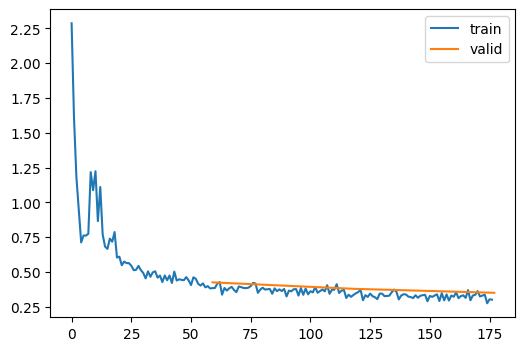

In [14]:
set_seed(42)
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 

f_init_weights = partial(init_weights, leaky=leak)
model = get_model(general_leaky_relu, norm=LayerNorm).apply(f_init_weights)
learn = MomentumLearner(model, dls, F.cross_entropy, lr =0.2, cbs=cbs)
learn.fit(3)

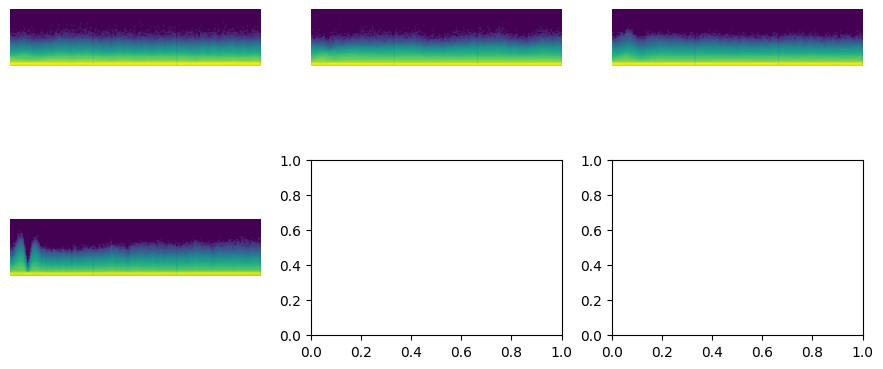

In [15]:
astats.color_dim()

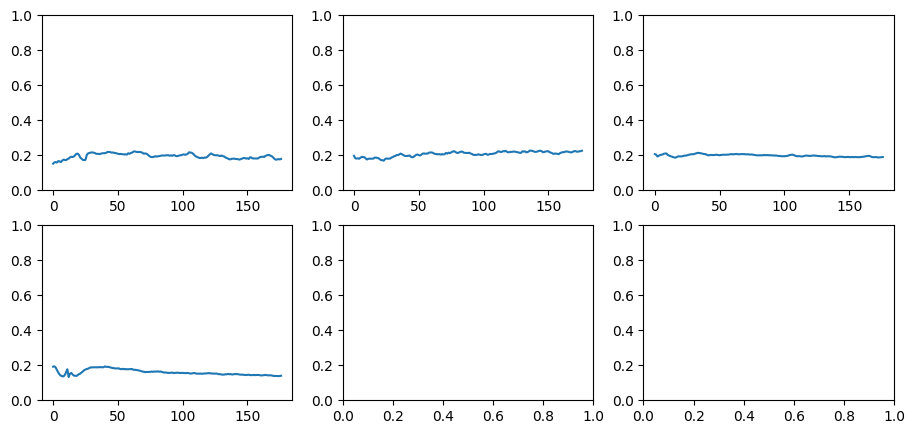

In [16]:
astats.dead_chart()

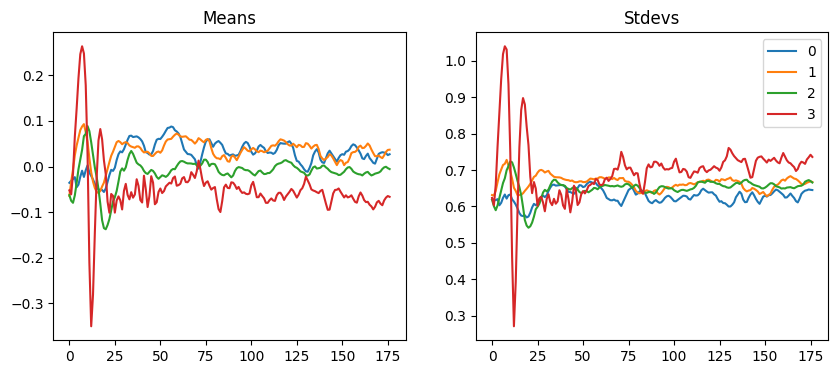

In [17]:
astats.plot_stats() 

LayerNorm and BatchNorm add a lot of complexity to the model, don't overuse them.

# Batch Normalization 
Idea: as we have seen if you ensure that the distribution of the activations have mean 0 and std 1 we have a good training. ISSUE: distribution of the inputs for the activations change during training so we get away from (0, 1) -> solution: normalize layer inputs during training! Normalization becomes part of the architecture.

In [47]:
torch.lerp(tensor(5.),tensor(15.), tensor(.75))
# torch.lerp(tensorA, TensorB, weight)
# outs: weighted mean of tensors ((1-weight)*A + weight*b)/2
# same as tensorA.lern(tensorB, weight)

tensor(12.5000)

In [44]:
class BatchNorm(nn.Module):
    '''
    Finds mean and variance of each channel.
    LayerNorms finds it for single obs
    BatchNorm finds if for single channel
    thus it requires:
    nf: number of filters
    
    Impo: for each channel finds m and sigma to shift/scale dist of activations
    for each channel. 
    -> weighted avg over batchs to have smooth learning of mults, adds params
    no particular single batch should screw us
    
    '''
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        '''
        mom in the weight of the moving avg look torch.lerp() above
        '''
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        
        # containers for moving avg of means and vars for each channel
        # var start at 1 cuz stuff/1 = stuff = no scaling
        # by def .9 of old values 
        # self.register_buffer <- these values are PART/SAVED of model
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        # update buffers; computes moving avg
        # takes a weighted avg of [n-1, n] values in buffer
        self.means.lerp_(m, self.mom) 
        self.vars.lerp_(v, self.mom)
        return m,v
    
    def forward(self, x):
        '''
        During training uses actual means/vars
        In validation uses moving avg means/vars
        '''
        if self.training:
            with torch.no_grad():
                m,v = self.update_stats(x)
        else:
            m,v = self.means, self.vars   
            
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds            

MulticlassAccuracy,loss,epoch,train
0.782,0.597,0,train
0.820,0.494,0,eval
0.859,0.387,1,train
0.835,0.452,1,eval
0.875,0.342,2,train
0.858,0.402,2,eval


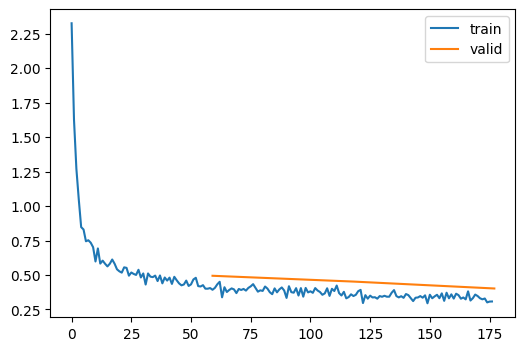

In [48]:
set_seed(42)
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 

f_init_weights = partial(init_weights, leaky=leak)
model = get_model(general_leaky_relu, norm=BatchNorm).apply(f_init_weights)
learn = MomentumLearner(model, dls, F.cross_entropy, lr =0.2, cbs=cbs)
learn.fit(3)

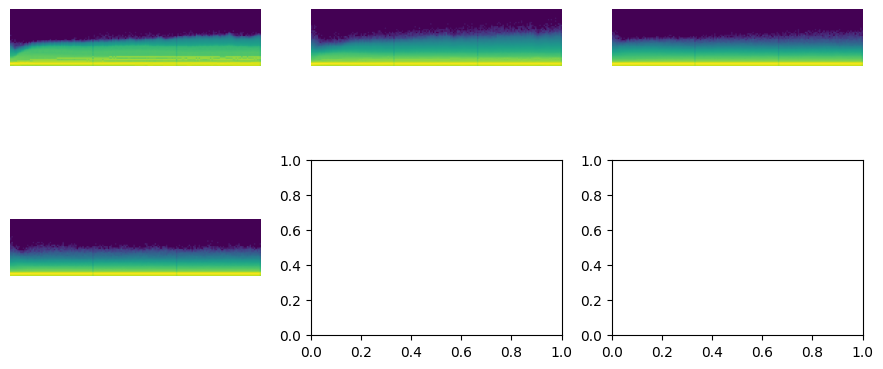

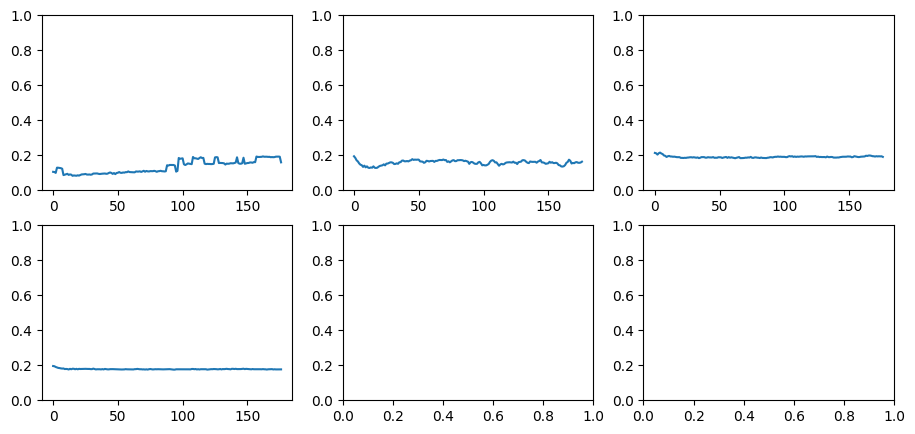

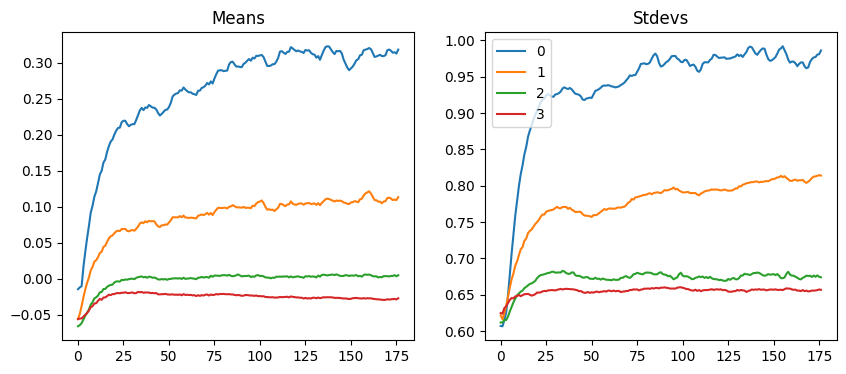

In [49]:
astats.plot_all()

# each time you train also try to double the lr!

MulticlassAccuracy,loss,epoch,train
0.795,0.562,0,train
0.843,0.435,0,eval
0.869,0.357,1,train
0.858,0.398,1,eval
0.883,0.315,2,train
0.866,0.374,2,eval


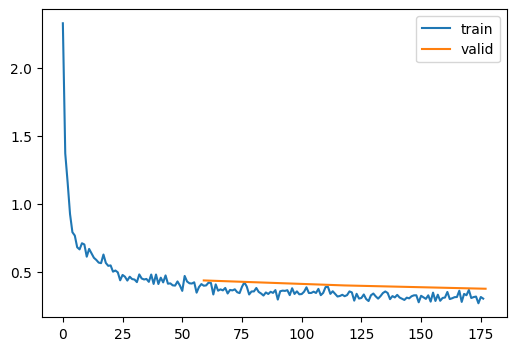

In [50]:
set_seed(42)
leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 

f_init_weights = partial(init_weights, leaky=leak)
model = get_model(general_leaky_relu, norm=BatchNorm).apply(f_init_weights)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

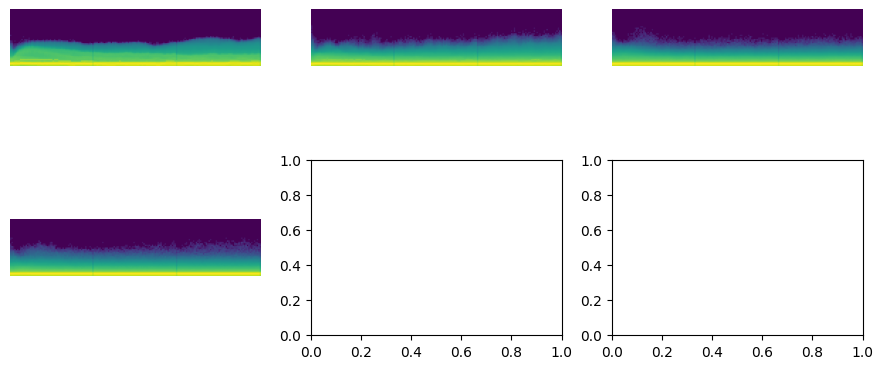

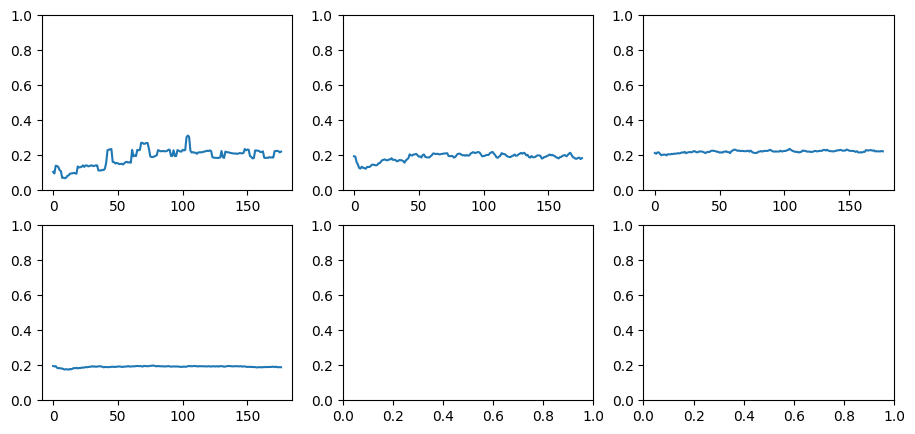

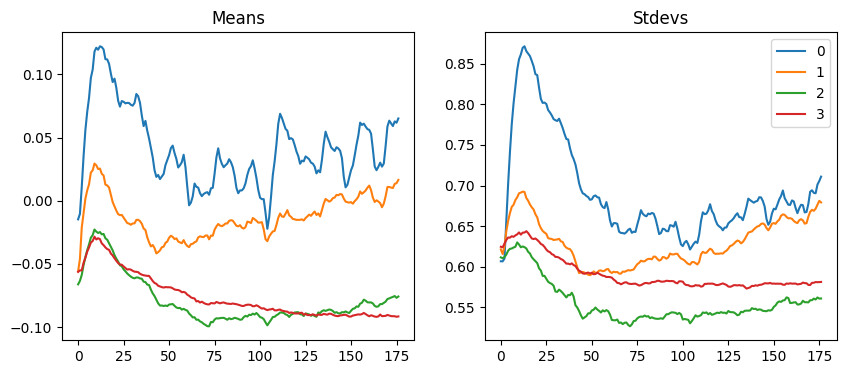

In [51]:
astats.plot_all()

# Different types of normalizations

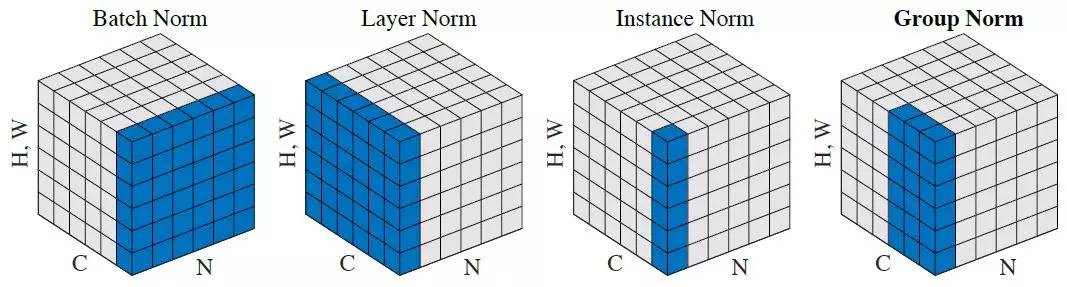

In [52]:
from IPython.display import Image
Image(filename="./norms.png")

Consider H,W concatenated on single axis.
Imagine sliding blue blocks rigidly
Img1: in batch norm we have average over N,H,W for every channel | 1 item per channel
Img2: in layer norm we average C,H,W for every N (N = batch_size, num of obs) | 1 item per obs
Img3: in Instance norm we average H,W for every N/C obs/channel | 1 item per channel/obs
Img4: arbitrarly groups a bunch of channels together, you choose how n for group. Maybe best.

# Let's try to go for 90% acc on train data

MulticlassAccuracy,loss,epoch,train
0.833,0.461,0,train
0.818,0.496,0,eval
0.880,0.329,1,train
0.850,0.413,1,eval
0.891,0.295,2,train
0.865,0.374,2,eval


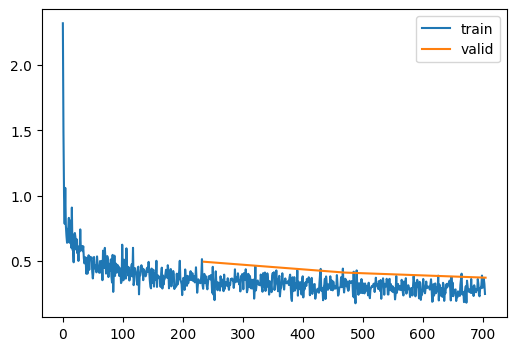

In [53]:
# 1) reduce batch size -> more batches more iteration steps

bs = 256
dls = DataLoaders.from_datasetDict(tds, bs) # recall here workers

set_seed(42)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 

# let's pass to nn.BatchNorm2d now that we impl it
model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

MulticlassAccuracy,loss,epoch,train
0.915,0.231,0,train
0.897,0.288,0,eval
0.920,0.217,1,train
0.898,0.286,1,eval


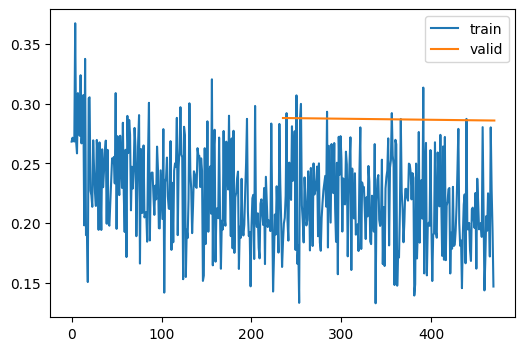

In [54]:
# 2) decreas lr to finetune from where we got before
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

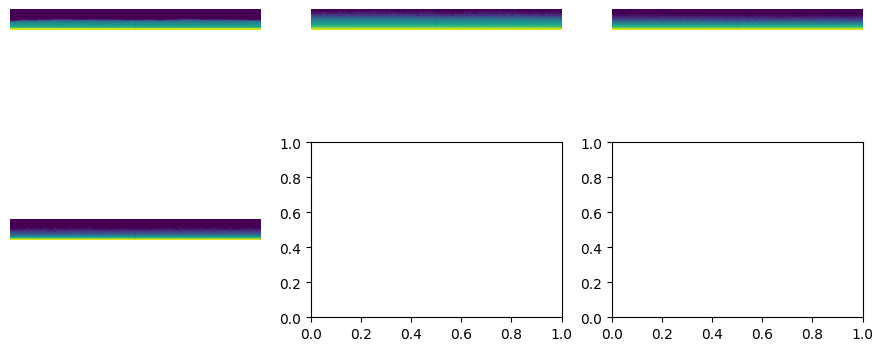

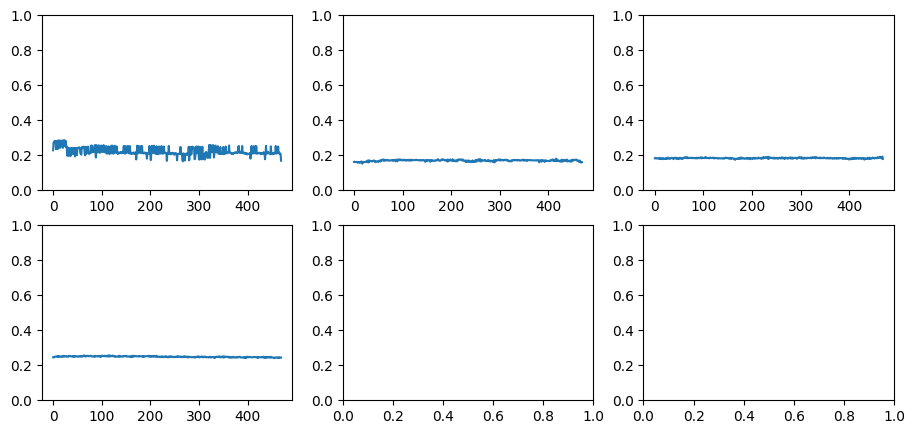

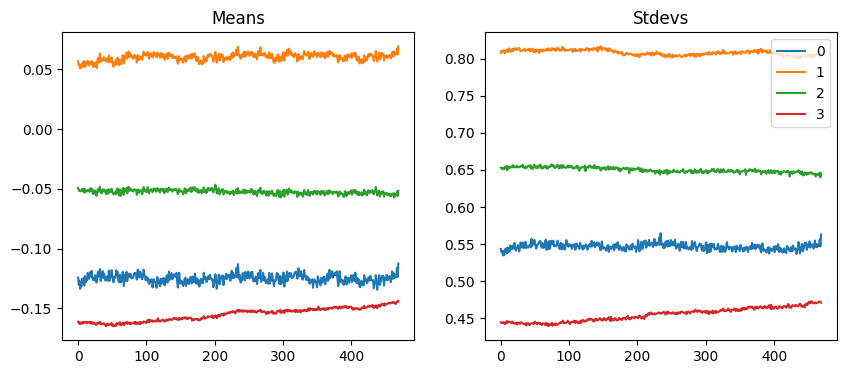

In [55]:
astats.plot_all()

In [56]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)